# Bitcoin Price and Sentiment Analysis

Connor Beard, Mishuk Dutta

We both are curious about Bitcoin's volatile prices and attempting to find a way to explain them. So when we began to think on said issue we realized that not many people who invest in Bitcoin understand the technology itself. So it left us wondering how do these people know when to buy or sell. The immediate though that popped into our heads was they did it based on public opinion. This lead to our project's question. 

# Can Bitcoin’s price be predicted by the sentimental analysis of Reddit posts in popular bitcoin/gaming subreddits? Does one do a better job of predicting?

We want to see if we can use some subreddit's sentiment to predict the price of Bitcoin. 

We decided on using 5 subreddits and grouping them into 2 groups that we think will have different effects on the price. 

* Crypto - r/Bitcoin, r/cryptocurrency, r/cryptomarkets
* Gaming - r/gaming, r/pcmasterrace

We chose the crypto subreddits as we felt that they would obviously be a good place to gather sentiment on the current prices of Bitcoin.

We also chose the gaming ones as we both had noticed that when Bitcoin was doing well the gaming subreddits were upset. Why? Because Bitcoin miners would buy more GPUs taking them away from the gamers. We felt then that their should be a inverse correlation between gaming sentiment and Bitcoin's price. 

With our question and subreddits chosen we were ready to dig into gathering data.

# Part 1: Data Gathering and Preprocessing

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import tweepy
import praw
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
from nltk.tokenize import TweetTokenizer
from nltk import word_tokenize
import string
from nltk.corpus import stopwords
import datetime
from nltk import punkt
import csv
import math
import os

For our project we knew we were going to gather data from reddit posts. We also knew that these posts could be filled with things that could potentially throw off our sentiment analyzer. So to start we created a text cleaner that processes the text in a post and only keep words important to the sentiment. Our function for this is below. 

In [2]:
cache_english_stopwords=stopwords.words('english')

sid = SentimentIntensityAnalyzer()

def text_clean(tweet, redd):
    if not redd:
        # Remove tickers
        sent_no_tickers=re.sub(r'\$\w*','',tweet)
    
        tw_tknzr=TweetTokenizer(strip_handles=True, reduce_len=True)
        temp_tw_list = tw_tknzr.tokenize(sent_no_tickers)
    else:
        temp_tw_list = word_tokenize(tweet)
        

     # Remove hyperlinks
    list_no_hyperlinks=[re.sub(r'https?:\/\/.*\/\w*','',i) for i in temp_tw_list]
    
    # Remove hashtags
    list_no_hashtags=[re.sub(r'#', '', i) for i in list_no_hyperlinks]
 
    # Remove Punctuation and split 's, 't, 've with a space for filter
    list_no_punctuation=[re.sub(r'['+string.punctuation+']+', ' ', i) for i in list_no_hashtags]
    
     #remove non alpha numeric
    list_no_back=[re.sub(r'[\W_]+', '', i) for i in list_no_punctuation]
    
    # Remove stopwords
    list_no_stopwords=[i for i in list_no_back if i.lower() not in     cache_english_stopwords]
    
    #remove btc stopwords
    btc_stop = {'btc', 'bitcoin', 'eth', 'crypto', 'curreny', 'bitcoinnews',
                'ethereum', 'altcoins', 'cryptolife', 'cryptocurrency', 'blockchain',
               'bitcoins', 'coinbase','litecoin', 'cryptocurrencies', 'https', '...'}
    
    list_no_btc=[i for i in list_no_stopwords if not i.lower() in btc_stop]
   
    # Remove multiple whitespace
    new_sent = ' '.join(list_no_btc)
    # Remove any words with 2 or fewer letters
    if not redd:
        filtered_list = tw_tknzr.tokenize(new_sent)
    else:
        filtered_list = word_tokenize(new_sent)
    list_filtered = [re.sub(r'^\w\w?$', '', i) for i in filtered_list]
  
    filtered_sent =' '.join(list_filtered)
    clean_sent=re.sub(r'\s\s+', ' ', filtered_sent)
    #Remove any whitespace at the front of the sentence
    clean_sent=clean_sent.lstrip(' ')
   
    return clean_sent

Next we wanted to create a function we could run and it gather many posts from our subreddits that we had not already gathered. The function below handles the 'not already gathered part'. It reads our current csv for a subreddit and stores all the posts we have gathered into a list. If we enounter a post in our function that exists in the list we go ahead and assume we have gathered all NEW most recent posts.

In [3]:
def lp_update(sub_name):
    
    last_posts = []
    
    if os.path.isfile(sub_name+'.csv'):
        sub = pd.read_csv(sub_name+'.csv')
        last_posts = sub['text'].values
    
    return last_posts


Finally we created our scraping function. 

This function uses reddit's API PRAW to gather at most the 1000 most recent posts in a given subreddit. If it encounters a post already in our csv for the subreddit it stops gathering. We were able to run this many times over the course of 3-4 days to build our csvs. 

In [4]:
def reddit_scrape(subreddit):
    client_id = '8_US9I43O5unJA'
    client_sec = 'onShy20mNJUYjGUiJmzBiq0cWAc'
    user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/65.0.3325.181 Safari/537.36'

    reddit = praw.Reddit(client_id=client_id, client_secret=client_sec, user_agent=user_agent)
    sub = reddit.subreddit(subreddit).new(limit=None)

    last_posts = lp_update(subreddit)
    
    submissions = []
    for submission in sub:

        row = []
    
        if text_clean(submission.title, True) in last_posts:
            break
        
        if text_clean(submission.title, True):
            
            row.append(text_clean(submission.title, True))
            row.append(sid.polarity_scores(text_clean(submission.title, True))['neg'])
            row.append(sid.polarity_scores(text_clean(submission.title, True))['neu'])
            row.append(sid.polarity_scores(text_clean(submission.title, True))['pos'])
            row.append(sid.polarity_scores(text_clean(submission.title, True))['compound'])
            row.append(submission.score)
            row.append(submission.gilded)
            row.append(datetime.datetime.fromtimestamp(submission.created).strftime('%m/%d/%Y %H:%M:%S'))

            submissions.append(row)

    if not (len(submissions) == 0):
        print len(submissions)
        print submissions[len(submissions)-1][7]
    row_name = ['text', 'neg', 'neu', 'pos', 'compund', 'score', 'golds', 'time']
        
    if not os.path.isfile(subreddit+'.csv'):
        with open(subreddit+'.csv', 'ab+') as csvfile:
            write = csv.writer(csvfile)
            write.writerow(row_name)
            csvfile.close()

    with open(subreddit+'.csv', 'ab+') as csvfile:
        write = csv.writer(csvfile)
        for row in submissions:
            try:
                write.writerow(row)
            except:
                print 'skipping'
        csvfile.close()
    

In [5]:
#DO NOT RUN DATA ALREADY SAVED INTO CSVs

'''
reddit_scrape('bitcoin')
reddit_scrape('gaming')
reddit_scrape('cryptocurrency')
reddit_scrape('cryptomarkets')
reddit_scrape('pcmasterrace')
'''

"\nreddit_scrape('bitcoin')\nreddit_scrape('gaming')\nreddit_scrape('cryptocurrency')\nreddit_scrape('cryptomarkets')\nreddit_scrape('pcmasterrace')\n"

To start this step we first needed to load our datasets into dataframes. We do this using the read_csv function in pandas on the csv files we created/gathered in part 1. 

In [6]:
btc = pd.read_csv('bitcoin.csv')
cc = pd.read_csv('cryptocurrency.csv')
cm = pd.read_csv('cryptomarkets.csv')
gmin = pd.read_csv('gaming.csv')
pcmr = pd.read_csv('pcmasterrace.csv')

price = pd.read_csv('finalized_data.csv')

Next we do some minor cleaning and processing of the data. 
* We change all the dates to datetime
* We remove posts with no sentiment
* We remove all posts that exist before our start cutoff time (April 9th)
* We combine the subreddits into their appropriate groups. 
    * crypto = r/bitcoin, r/cryptocurrency, r/crytpomarketing. 
    * gaming = r/gaming, r/pcmasterrace.

In [7]:
btc['time'] = pd.to_datetime(btc['time'])
cc['time'] = pd.to_datetime(cc['time'])
cm['time'] = pd.to_datetime(cm['time'])
gmin['time'] = pd.to_datetime(gmin['time'])
pcmr['time'] = pd.to_datetime(pcmr['time'])
price['Time'] = pd.to_datetime(price['Time'])

#remove all posts with no sentiment
btc = btc[btc.compund != 0]
cc = cc[cc.compund != 0]
cm = cm[cm.compund != 0]
gmin = gmin[gmin.compund != 0]
pcmr = pcmr[pcmr.compund != 0]

#remove all none important dates
btc = btc[btc.time >= '04/09/2018']
cc = cc[cc.time >= '04/09/2018']
cm = cm[cm.time >= '04/09/2018']
gmin = gmin[gmin.time >= '04/09/2018']
pcmr = pcmr[pcmr.time >= '04/09/2018']

#combine the crypto subreddit data and gaming data
crypto_list = [btc, cc, cm]
gaming_list = [gmin, pcmr]

crypto = pd.concat(crypto_list)
gaming = pd.concat(gaming_list)

#reduce price to just Time and Coinbase
price = price.filter(['Time', 'coinbase'], axis=1)

#show how data is stored
crypto.info()
gaming.info()
price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1067 entries, 0 to 1034
Data columns (total 8 columns):
text       1067 non-null object
neg        1067 non-null float64
neu        1067 non-null float64
pos        1067 non-null float64
compund    1067 non-null float64
score      1067 non-null int64
golds      1067 non-null int64
time       1067 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 75.0+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1867 entries, 3 to 1172
Data columns (total 8 columns):
text       1867 non-null object
neg        1867 non-null float64
neu        1867 non-null float64
pos        1867 non-null float64
compund    1867 non-null float64
score      1867 non-null int64
golds      1867 non-null int64
time       1867 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 131.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total

The next cells handle more preprocessing. We added functions to make it easier on us.
1. Adds two columns to a dataframe for the date and hour of the reddit post
2. Gets the mean sentiment in an hour timeframe using the reddit posts within that particular hour
3. Calculates the change in mean hour to hour based on the above means

In [8]:
#split sentiments into hours
#it is a groupby object so to access the elements you can 
#loop over with a for loop for each hour and dataframe pair
'''
example
for datehour, df in crypto_hours:
    datehour will be the key so 04/09 0:00
    and df will be the observations within that hour
'''
def hour_split(df):
    df['date'] = df['time'].dt.date
    df['hour'] = df['time'].dt.hour
    grps = df.groupby(['date', 'hour'])
    
    return grps

In [9]:
#get mean sentiment for each hour
#returns the hours array and the means array
#the indexes match up like
# 04/09 0:00 ---> .26746
def get_mean(grp):
    hours = []
    means = []
    for hour, df in grp:
        add_hour = datetime.time(hour=hour[1].item())
        hours.append(datetime.datetime.combine(hour[0], add_hour))
        means.append(df.compund.mean())
        
    return hours, means

In [10]:
#get changes in mean sentiment by hour
#returns a list that matches the dates returned
#by the get_mean array
def get_change_mean(means):
    change = []
    for i in range(0, len(means)-1):
        change.append(means[i+1] - means[i])
    
    change.append(np.mean(change[-3:]))
    
    return change

In [11]:
#adds a column to price that stores the change in price
price['change'] = price['coinbase'] - price['coinbase'].shift(-1)
price['change'] = price['change'].fillna(price['change'].mean())
price['change'] = -price['change']

In [12]:
crypto_hours = hour_split(crypto)
gaming_hours = hour_split(gaming)

In [13]:
crypto_dates, crypto_means = get_mean(crypto_hours)
gaming_dates, gaming_means = get_mean(gaming_hours)

In [14]:
#get changes in means
crypto_change = get_change_mean(crypto_means)
gaming_change = get_change_mean(gaming_means)

We wanted our newly created data to be easy to use later on so we put it into dataframes for each group.

In [15]:
#converted lists to dataframe for ease of use
cdf2 = pd.DataFrame({'time': crypto_dates, 'mean' : crypto_means, 'change': crypto_change})
gdf2 = pd.DataFrame({'time': gaming_dates, 'mean' : gaming_means, 'change': gaming_change})

#cdf2 = cdf2.set_index('time')
#gdf2 = gdf2.set_index('time')

We also wanted to make sure that our datetimes were lined up properly between our price dataset and our crypto, gaming datasets so here we make two new dataframes that only contain datetimes that exist within their respective subreddits datasets. 

In [16]:
#prepare price for use with hourly data
#only keep the hours we have data for
price_crypto = price[price['Time'].isin(crypto_dates)]
price_gaming = price[price['Time'].isin(gaming_dates)]

We knew we might want to do something with labels instead of the actual sentiment scores. Here we created a function that labels things 1 (pos), -1 (neg), 0 (neu). We wanted the posts to mostly have some sort of sentiment so we set the bar low for what constituted a positive or negative post at .25 and -.25 respectively. 

In [17]:
#add a label to each row in the dataframes for pos/neg/neu
def labeling(row):
    if row['compund'] >= .25:
        return 1
    elif row['compund'] <= -.25:
        return -1
    else:
        return 0
    
crypto['label'] = crypto.apply(lambda row: labeling(row), axis=1)
gaming['label'] = gaming.apply(lambda row: labeling(row), axis=1)

crypto.head()

,text,neg,neu,pos,compund,score,golds,time,date,hour,label
0,Price Boost History Side,0.000,0.526,0.474,0.4019,1,0,2018-04-12 00:09:00,2018-04-12,0,1
2,Illegal Trading Flourishing India RBI Ban,0.643,0.357,0.000,-0.8020,0,0,2018-04-11 23:44:00,2018-04-11,23,-1
4,Good news USA Japan,0.000,0.508,0.492,0.4404,1,0,2018-04-11 23:24:00,2018-04-11,23,1
5,Hey guys made cool Apparel feedback would grea...,0.000,0.543,0.457,0.7089,1,0,2018-04-11 23:21:00,2018-04-11,23,1
6,Today got lightning sticker blockstream really...,0.000,0.782,0.218,0.4201,1,0,2018-04-11 23:19:00,2018-04-11,23,1


# Part 2: EDA

After all of the processing and gathering we are now finally ready to dive into and look at the data. The first thing we wanted to visualize was the distribution of positive, negative, and neutral posts. 

Text(0.5,1,u'gaming')

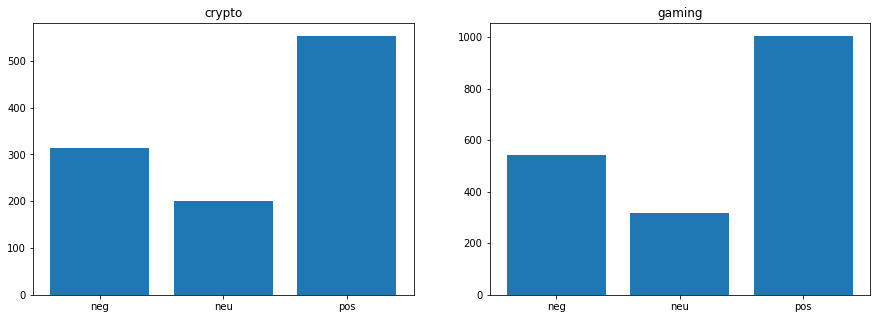

In [18]:
#bar charts of labels 
clabel = crypto['label'].value_counts()
glabel = gaming['label'].value_counts()

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15, 5))
ax1.bar(['pos','neg','neu'], clabel.values)
ax1.set_title('crypto')
ax2.bar(['pos','neg','neu'], glabel.values)
ax2.set_title('gaming')

Above we can see that both groups are pretty positive in the posts that are made. This worried us slightly for crypto as we know Bitcoin's price has been down. We believe that it is possible the subreddit's stay positive despite the hate, and bad publicity given to Bitcoin. This could affect results greatly. For gaming we had assumed its positivity as its main focus in building PCs and gaming, both of which make many people happy. We may be reaching by saying it has an inverse correlation with Bitcoin because only a small number of posts made there relate to the cryptocurrency. 

Next we wanted to visualize the sentiment over time in the reddit posts. We wanted to see if there were any noticable trends and also to see if those trends potentially matched Bitcoin's prices. 

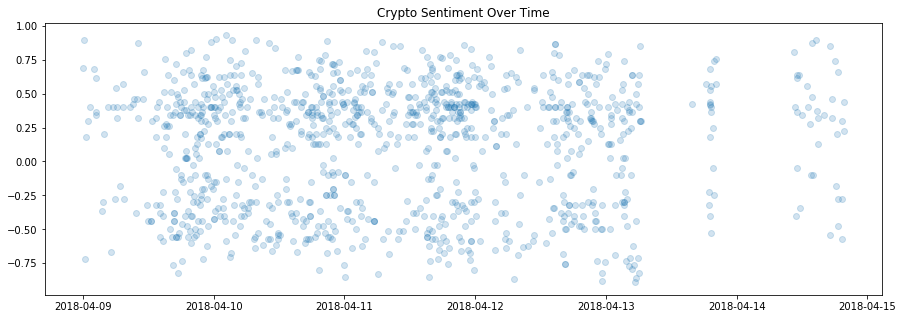

In [19]:
#raw crypto sentiment over time
fig, ax = plt.subplots(figsize=(15,5))
ax.plot_date(crypto['time'], crypto['compund'], alpha=0.2)
ax.set(title='Crypto Sentiment Over Time')
plt.show()

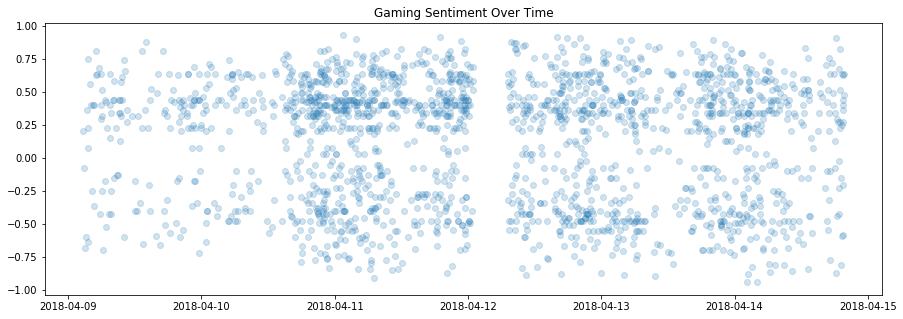

In [20]:
#raw gaming sentiment over time
fig, ax = plt.subplots(figsize=(15,5))
ax.plot_date(gaming['time'], gaming['compund'], alpha=0.2)
ax.set(title='Gaming Sentiment Over Time')
plt.show()

Using the raw sentiments points for each post in both groups turned out to show no clear trends. It also showed us that we had some holes in our data but we just chose to ignore them as there was no way for us to fill them well. 

We decided instead of using the raw points to use means of sentiment by hour and look at that graph over time. This is done below.

[]

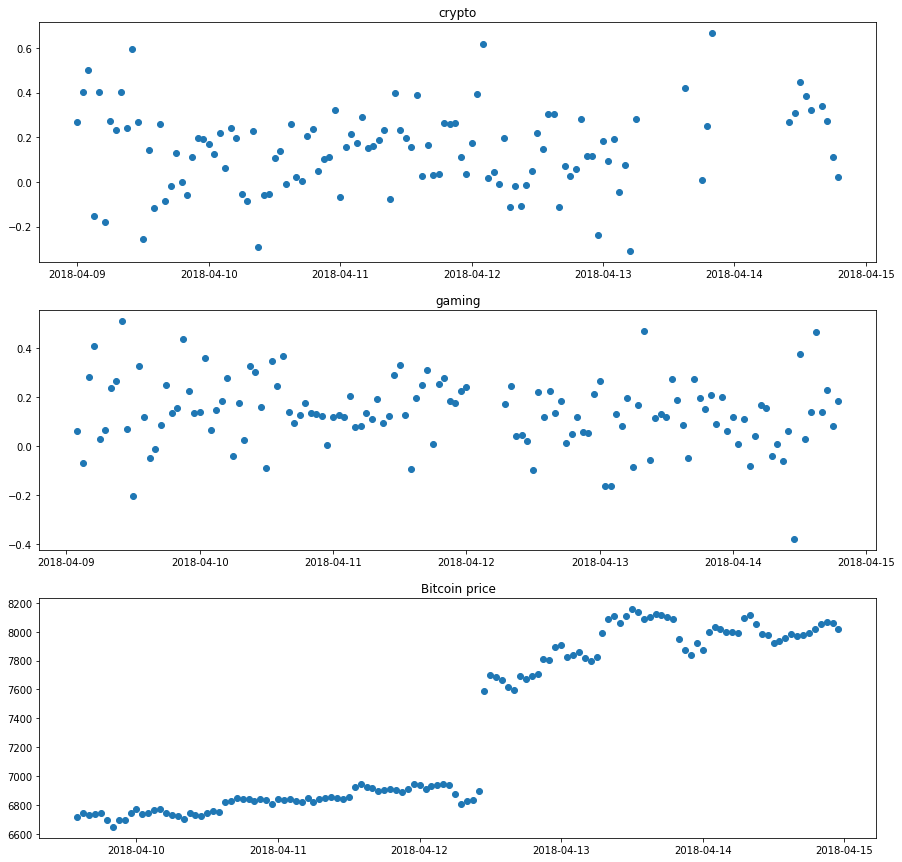

In [21]:
#Sentiment average by hour crypto
fig, (ax1, ax2, ax3) = plt.subplots(3, 1,figsize=(15, 15))
ax1.plot_date(crypto_dates, crypto_means)
ax1.set_title('crypto')
#Sentiment average by hour gaming
ax2.plot_date(gaming_dates, gaming_means)
ax2.set_title('gaming')
#bitcoin price
ax3.plot_date(price['Time'], price['coinbase'])
ax3.set_title('Bitcoin price')
plt.plot()

When we looked at these plots we noticed a VERY slight uptrend in crypto's sentiment and also what we believe to be a VERY slight downtrend in gaming's sentiment. 

This was good news for us as when we looked at Bitcoin's price data it had a big increase in price over time. So an uptrend for crypto would match our predictions and a downtred for gaming would as well!

We also noticed the massive jump in Bitcoin's price and wanted to look into it a little more.

In [22]:
print price.iloc[price['change'].idxmax()]

Time        2018-04-12 10:00:00
coinbase                6897.34
change                   691.43
Name: 68, dtype: object


In [23]:

for i in range(2,12):
    print cdf2[cdf2['time'] == datetime.datetime(2018,4,12,i)]
    
print ''
for i in range(7,12):
    print gdf2[gdf2['time'] == datetime.datetime(2018,4,12,i)]

      change      mean                time
74 -0.598489  0.617933 2018-04-12 02:00:00
      change      mean                time
75  0.026789  0.019444 2018-04-12 03:00:00
      change      mean                time
76 -0.056861  0.046233 2018-04-12 04:00:00
      change      mean                time
77  0.206752 -0.010627 2018-04-12 05:00:00
      change      mean                time
78 -0.309058  0.196125 2018-04-12 06:00:00
    change      mean                time
79  0.0925 -0.112933 2018-04-12 07:00:00
      change      mean                time
80 -0.088133 -0.020433 2018-04-12 08:00:00
      change      mean                time
81  0.093767 -0.108567 2018-04-12 09:00:00
     change    mean                time
82  0.06325 -0.0148 2018-04-12 10:00:00
    change     mean                time
83  0.1715  0.04845 2018-04-12 11:00:00

     change      mean                time
71  0.07079  0.171672 2018-04-12 07:00:00
      change      mean                time
72 -0.202296  0.242462 2018-

We looked at our datasets that contained our mean sentiments and change in sentiments around the specified time point of the big jump. 

What we noticed in crypto was a few hours before the big jump sentiments seemed to be positive/higher but right before the jump sentiment was lower. this introduced the idea of a delay into our heads.

With gaming sentiment decreased leading up and after the big jump. There was a very small increase in sentiment the hour leading up to the jump but for the most part it was on a downward trend which would match our prediction!


We now are considering the idea of change in price as a response variable to our predictors. We decided to look at that idea below.

[]

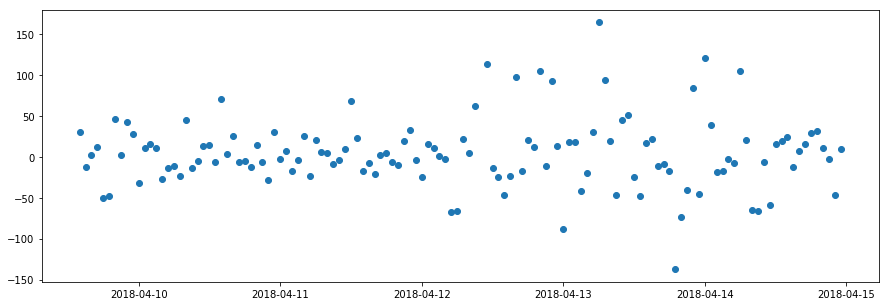

In [24]:
#change in bitcoin price - biggest jump
tmp = price
tmp = tmp.drop(tmp['change'].idxmax())
fig, ax = plt.subplots(figsize=(15,5))
ax.plot_date(tmp['Time'], tmp['change'])
plt.plot()

[]

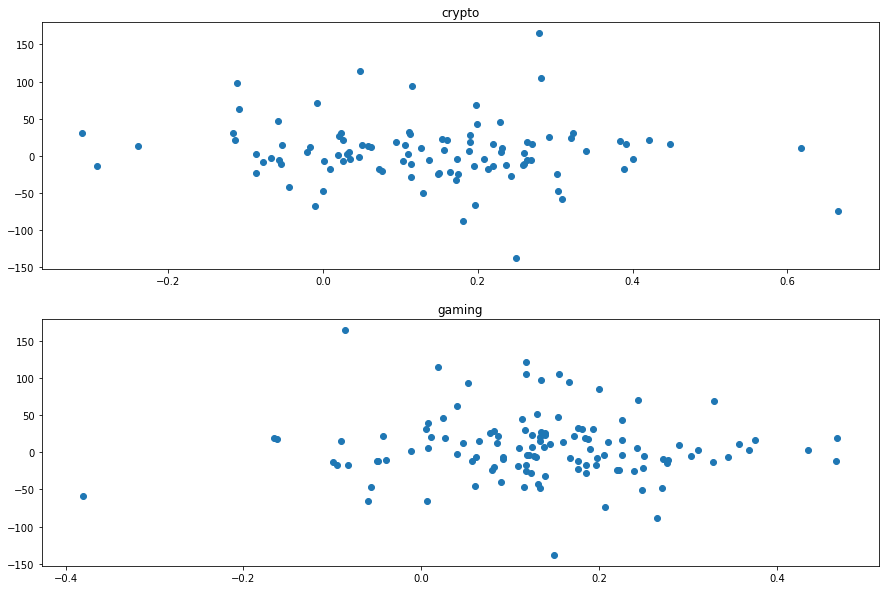

In [25]:
#sentiment vs. change in price
joined_crypt = pd.merge(left=cdf2, right=price, left_on='time', right_on='Time')#.filter(['time', 'mean', 'change_x', 'change_y'])
joined_crypt.set_index('time')
joined_gaming = pd.merge(left=gdf2, right=price, left_on='time', right_on='Time').filter(['time', 'mean', 'change_x', 'change_y'])
joined_gaming.set_index('time')


joined_crypt = joined_crypt.drop(joined_crypt['change_y'].idxmax())
joined_gaming = joined_gaming.drop(joined_gaming['change_y'].idxmax())

fig, (ax,ax1) = plt.subplots(2,1,figsize=(15,10))
ax.scatter(joined_crypt['mean'], joined_crypt['change_y'])
ax.set_title('crypto')
ax1.scatter(joined_gaming['mean'], joined_gaming['change_y'])
ax1.set_title('gaming')

plt.plot()

Here we joined our datasets of price with gaming and it with crypto as well to create these graphs showing average sentiment by hour as a predictor for change in price. 

We were disappointed to see no trend in either of the graphs. As sentiment increases in crypto there is no trend that shows bitcoins change in price staying postive as sentiment is positive and positive as sentiment is negative for gaming. We didn't want to trash this idea though as we felt we could be failing to see something. 

In the next graphs we wanted to look at change in sentiment as a predictor for change in price.

[]

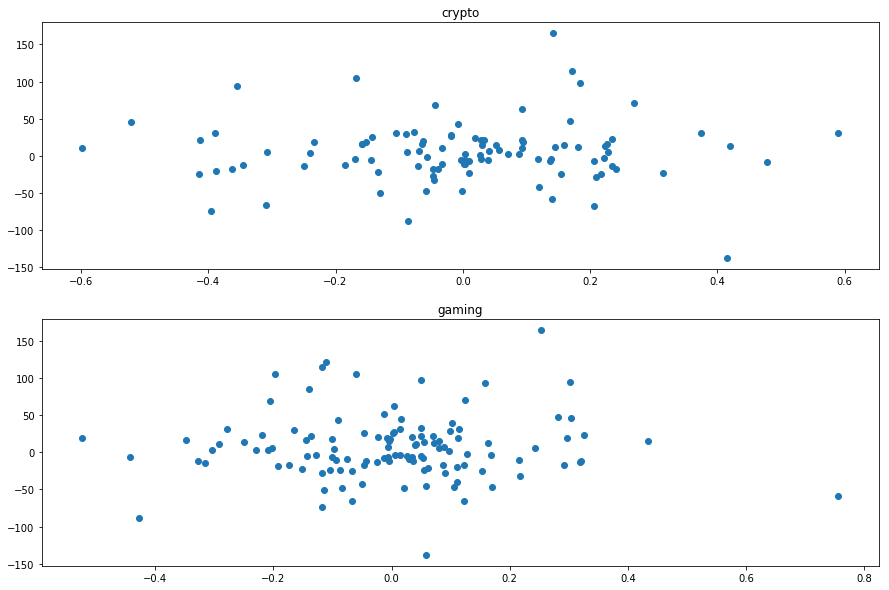

In [26]:
#change in sentiment vs. change in price
#removed biggest proce change for clarity in graph
fig, (ax,ax1) = plt.subplots(2,1,figsize=(15,10))
ax.scatter(joined_crypt['change_x'], joined_crypt['change_y'])
ax1.scatter(joined_gaming['change_x'], joined_gaming['change_y'])
ax.set_title('crypto')
ax1.set_title('gaming')


plt.plot()

Again we were disappointed with our results here. We wanted to see positive price changes with positive sentiment change in crypto and positive with negative in gaming. Again although we didn't get the results we wanted we decided to press on into our model building with this group of parameters in mind. 

# Part 3: Regression

# Setting up Dataframes
Breaking Down the DataFrames for Crypto and Gaming subs to categorize by date and hour.

Then we mean all the compound values for each hour and store it in the DataFrames for each date

Then we add numeric values to sentiments -50,0,50 depending on neg,neu,pos respectively


In [1056]:
###############
#
#Group data by time hours, then merge with price Change [GROUPS BY DATE AND HOUR]
#SMall sample size
#Represent Labels sentimets by numbers
#
################value
def hour_split_lower(df):
    df['date'] = df['Time'].dt.date
    df['hour'] = df['Time'].dt.hour
    df = df.drop(['Time'], axis=1)
    df = df[['date', 'hour','coinbase','change']].copy()
    return df

##give numbers to the label for better visual representation

def numeric_labels(row):
    l = 50
    if row['label'] == 'POS':
        return l
    elif row['label'] == 'NEG':
        return -l
    else:
        return 0

crypto_grouped = crypto.groupby(['date', 'hour']).mean().reset_index() #Grab mean of compound for hour of each Date
gaming_grouped = gaming.groupby(['date', 'hour']).mean().reset_index()
price_grouped = hour_split_lower(price)
price_grouped = price_grouped.groupby(['date', 'hour']).mean().reset_index().copy() 
crypto_price = pd.merge(crypto_grouped, price_grouped,  how='left', left_on=['date','hour'], right_on = ['date','hour']).copy()
gaming_price = pd.merge(gaming_grouped, price_grouped,  how='left', left_on=['date','hour'], right_on = ['date','hour']).copy()

gaming_price['label'] = gaming_price.apply(lambda row: labeling(row), axis=1)
gaming_price['n_label'] = gaming_price.apply(lambda row: numeric_labels(row), axis=1)

crypto_price['label'] = crypto_price.apply(lambda row: labeling(row), axis=1)
crypto_price['n_label'] = crypto_price.apply(lambda row: numeric_labels(row), axis=1)
crypto_price.head(5)


,date,hour,neg,neu,pos,compund,score,golds,coinbase,change,label,n_label
0,2018-04-09,0,0.150000,0.48720,0.362800,0.267460,294.4,0.0,7060.724767,39.497922,POS,50
1,2018-04-09,1,0.000000,0.59700,0.403000,0.401900,80.0,0.0,7100.222689,38.055096,POS,50
2,2018-04-09,2,0.000000,0.49675,0.503250,0.498600,13.5,0.0,7138.277785,-44.277796,POS,50
3,2018-04-09,3,0.123667,0.77900,0.097333,-0.151633,31.0,0.0,7093.999989,32.630909,NEG,-50
4,2018-04-09,4,0.000000,0.52600,0.474000,0.401900,159.0,0.0,7126.630898,-6.767970,POS,50


# Breaking Down dates into Hours
With all the data gathered, we break down the range of dates into hours. We do so by converting the hour tabs into a continious form from 0 to max Number of Dates X hours. 

Our DataFrame is already sorted by date and hours for each date. So we can simply convert the hours to continious format and drop the Date



In [1055]:
## Hourly BreakDown from dates  2018-04-09 to 2018-04-14

crypto_price_hourly = pd.DataFrame({'Hours': np.arange(len(crypto_price)), 'change': crypto_price['change'],
                       'compund':  crypto_price['compund'],'change': crypto_price['change'],'price':crypto_price['coinbase'],
                                    'label':crypto_price['label'], 'n_label':crypto_price['n_label']})

gaming_price_hourly = pd.DataFrame({'Hours': np.arange(len(gaming_price)), 'change': gaming_price['change'],
                       'compund':  gaming_price['compund'],'price':gaming_price['coinbase'],
                                    'n_label':gaming_price['n_label'], 'label':gaming_price['label']})
gaming_price_hourly.head(5)

,Hours,change,compund,label,n_label,price
0,0,-44.277796,0.062550,NEU,0,7138.277785
1,1,32.630909,-0.071586,NEG,-50,7093.999989
2,2,-6.767970,0.280586,POS,50,7126.630898
3,3,-11.859720,0.407986,POS,50,7119.862928
4,4,14.214823,0.029322,NEU,0,7108.003208


In [996]:
#REGRESSIONS START HERE
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
plt.rcParams['figure.figsize'] = 7,7

# Graph that shows Price changes Over the Hours

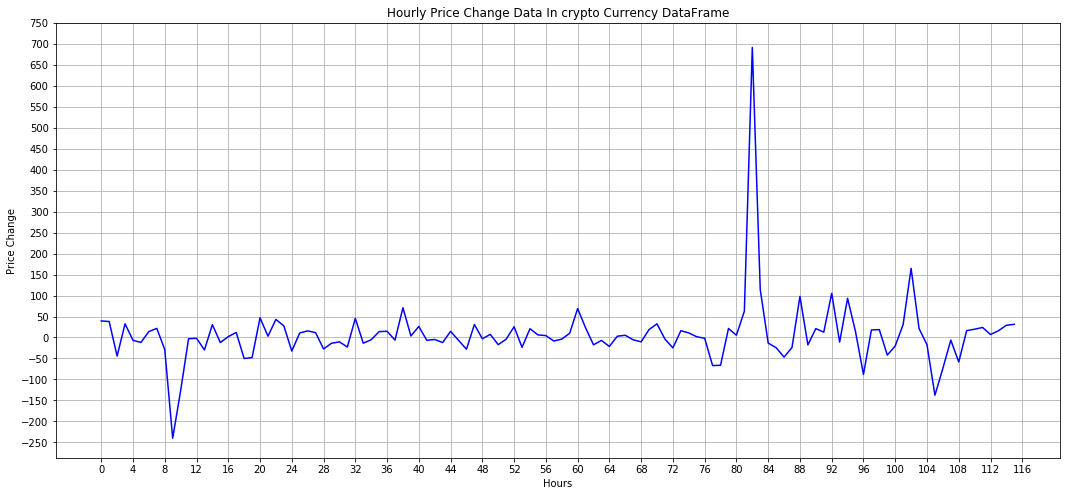

In [997]:
##########
# Hourly Price Change for Crypto
##########
plt.rcParams['figure.figsize'] = 18,8
plt.plot(crypto_price_hourly['Hours'],crypto_price_hourly['change'],  color='blue')
plt.xticks(np.arange(0, len(crypto_price_hourly)+1, 4))
plt.yticks(np.arange(-250, crypto_price_hourly['change'].max()+100, 50))
plt.grid()
plt.title('Hourly Price Change Data In crypto Currency DataFrame')
plt.xlabel('Hours')
plt.ylabel('Price Change')
plt.show()


# Linear Regression: Our Research relies on Sentiment. 

Our whole reseach relies on the dependency of a variable on another known Variable. As such, Linear regression was the best regression model for us.

Aother reason for a linear Regression Model is that, out sample Sizes after pre-processing are less than 150. Running other models like Logistic Regression would provide low Accuracy Results

We fit the model using the current Data that we Have on Crypto and Gaming subredding Sentiment

We are predicting Price change, not the amount of change. As such, we needed to make sure our variables we clear to indicate what's going on.

The predicted Values had to be re-altered for visual representation. n_label is just numbering for the sentiment. We had to re-evaluate to fix visual disperancy 


In [998]:
###
# Crypto Sentiment: Create Linear Regression
# number positive and negative sentiments by numbers (Range -50 0, 50)
#
###
lm = LinearRegression()
changesC = []
hourly_compound_crypto = crypto_price_hourly['n_label'].values.reshape(-1,1)
hourly_change_crypto = crypto_price_hourly['change'].values.reshape(-1,1)
  
lm.fit(hourly_compound_crypto,hourly_change_crypto)
predicted_hourly_change = lm.predict(hourly_compound_crypto)
for i in (predicted_hourly_change):
    if i<0:
        changesC.append(50)
    elif i >15:
        changesC.append(-50)
    else:
        changesC.append(0)


# Using the Fitted model For Crypto

Sentiment is something that changes over time. We acknowledged the fact that users weren't always around their laptops/Desktops. We decided to add a delay to mitigate this.


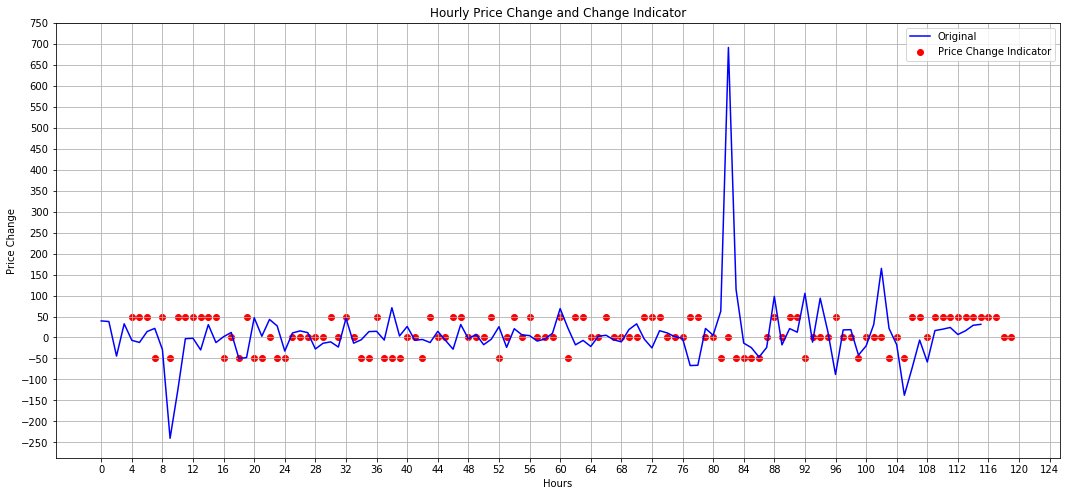

In [1044]:
n = 4
#
# Fit predicted model over the original with a time difference for prediction to take place 
#
plt.rcParams['figure.figsize'] = 18,8
new_hours = np.arange(n,crypto_price_hourly['Hours'].max()+n+1,1)

plt.plot(crypto_price_hourly['Hours'],crypto_price_hourly['change'],  color='blue', label ='Original')
plt.scatter(new_hours, changesC, label ='Price Change Indicator', color='red')

plt.xticks(np.arange(0, len(crypto_price_hourly)+10, 4))
plt.yticks(np.arange(-250, crypto_price_hourly['change'].max()+100, 50))
plt.rcParams['figure.figsize'] = 20,15
plt.grid()
plt.title('Hourly Price Change and Change Indicator')
plt.xlabel('Hours')
plt.ylabel('Price Change')
plt.legend()

plt.show()
print 


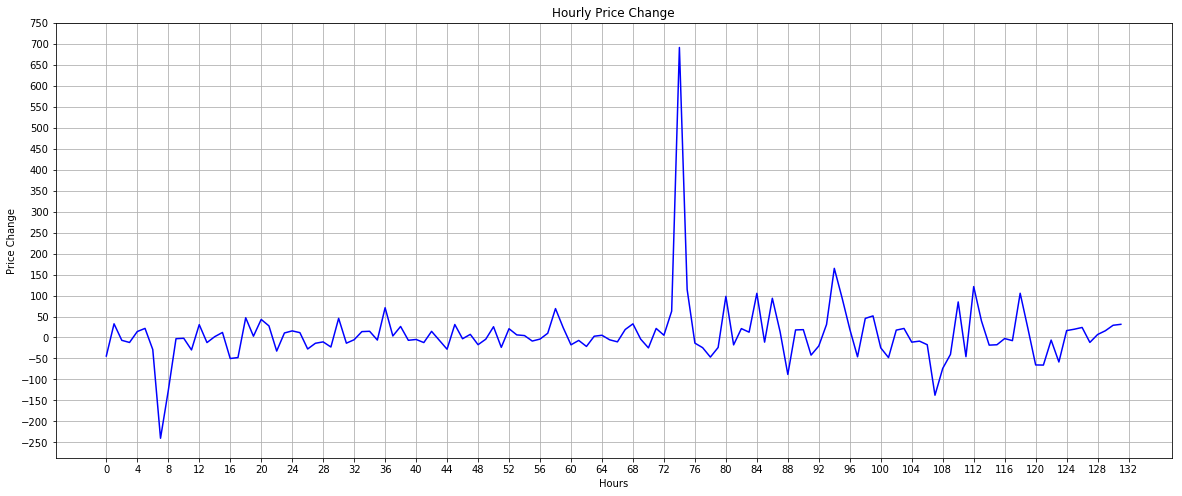

In [1000]:
##########
# Hourly Price Change for gaming
##########
plt.rcParams['figure.figsize'] = 20,8
plt.plot(gaming_price_hourly['Hours'],gaming_price_hourly['change'],  color='blue')
plt.xticks(np.arange(0, len(gaming_price_hourly)+1, 4))
plt.yticks(np.arange(-250, gaming_price_hourly['change'].max()+100, 50))
plt.grid()
plt.title('Hourly Price Change')
plt.xlabel('Hours')
plt.ylabel('Price Change')
plt.show()


In [1011]:
###
# Gaming Sentiment: Create Linear Regression
# number positive and negative sentiments by numbers (Range -50 0, 50)
# 
###
lm = LinearRegression()
changes = []
hourly_compound_gaming = gaming_price_hourly['n_label'].values.reshape(-1,1)
hourly_change_gaming = gaming_price_hourly['change'].values.reshape(-1,1)
  
lm.fit(hourly_compound_gaming,hourly_change_gaming)
predicted_hourly_change = lm.predict(hourly_compound_gaming)
for i in (predicted_hourly_change):
    if i<0:
        changes.append(50)
    elif i >15:
        changes.append(-50)
    else:
        changes.append(0)


# Making a model for Gaming Subreddit 


132


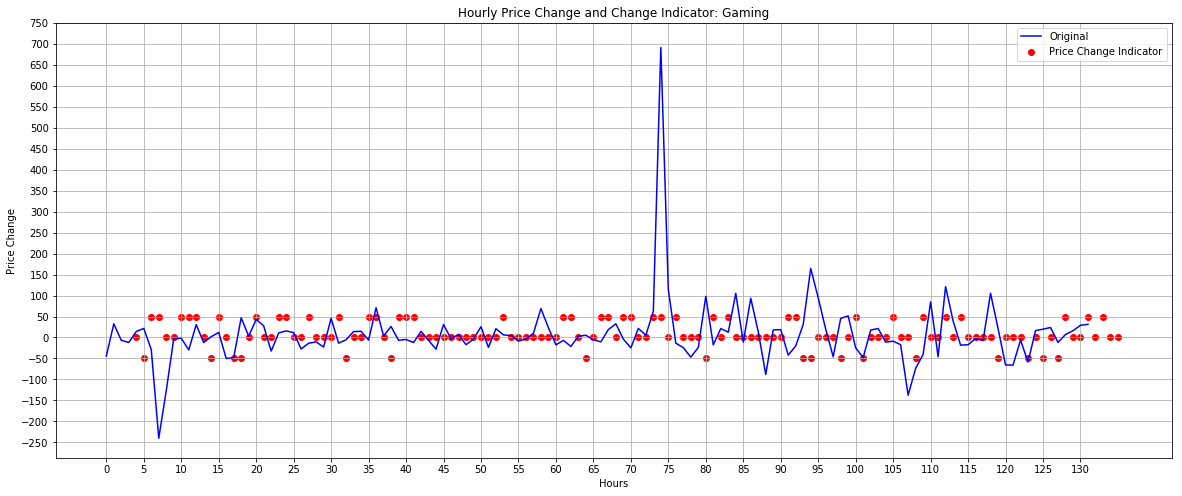

In [1045]:
n = 4 # Hours to wait for modeling to kick in

##########
# Fit Model over Gaming
##########
plt.rcParams['figure.figsize'] = 20,8

new_hours = np.arange(n,gaming_price_hourly['Hours'].max()+n+1,1)
print len(new_hours)
plt.plot(gaming_price_hourly['Hours'],gaming_price_hourly['change'],  color='blue',label='Original')
#plt.plot(new_hours,predicted_hourly_change,  color='red', label ='Predicted')
plt.scatter(new_hours, changes, label ='Price Change Indicator', color='red')
plt.xticks(np.arange(0, len(gaming_price_hourly)+1, 5))
plt.yticks(np.arange(-250, gaming_price_hourly['change'].max()+100, 50))
plt.grid()
plt.legend()
plt.title('Hourly Price Change and Change Indicator: Gaming')
plt.xlabel('Hours')
plt.ylabel('Price Change')
plt.show()

# Fitting the predicted Model we got from Gaming Subreddit onto the Crypto

Bitcoin is discussed in both subs and should have similar reactions given the fact that PC systems are one of the major bitcoin mining systems. Plotting the predictions we got from GAMING subs over crtypto subs should give us a better accuracy check since the DATA TIME FRAME was the same for both

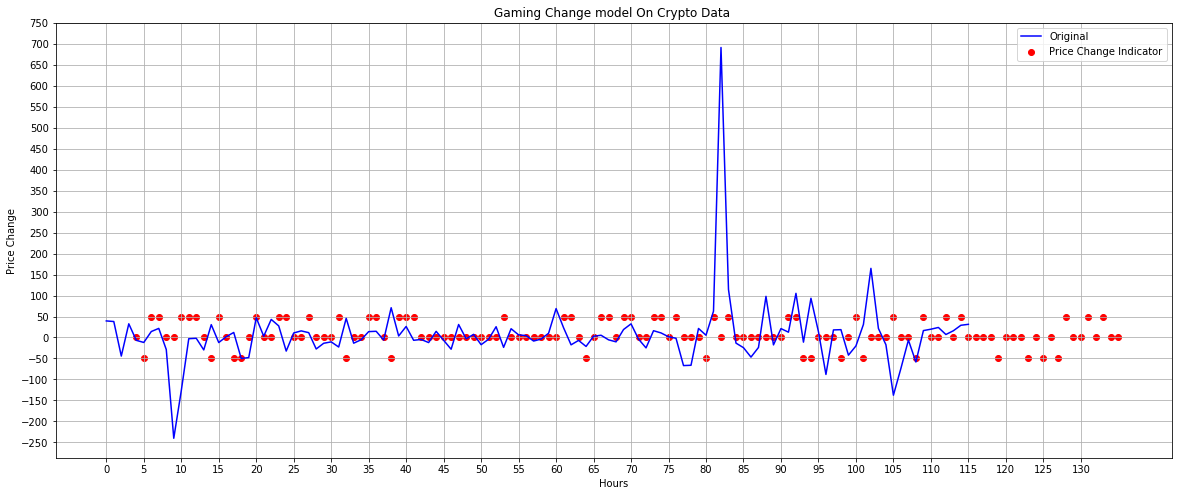

In [1047]:
n = 4
new_hours = np.arange(n,gaming_price_hourly['Hours'].max()+n+1,1)
plt.plot(crypto_price_hourly['Hours'],crypto_price_hourly['change'],  color='blue',label='Original')
plt.scatter(new_hours, changes, label ='Price Change Indicator', color='red')
plt.xticks(np.arange(0, len(gaming_price_hourly)+1, 5))
plt.yticks(np.arange(-250, gaming_price_hourly['change'].max()+100, 50))
plt.grid()
plt.legend()
plt.title('Gaming Change model On Crypto Data ')
plt.xlabel('Hours')
plt.ylabel('Price Change')
plt.show()

# SNS and REG plots

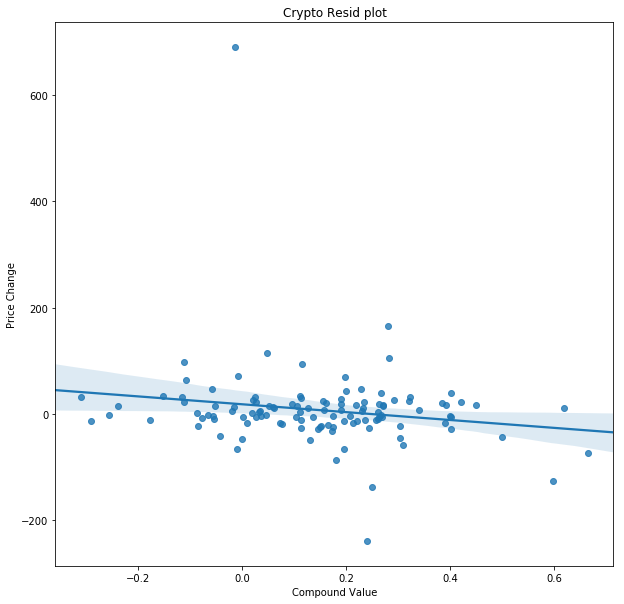

In [1052]:
sns.regplot('compund', 'change', crypto_price_hourly , fit_reg=True )
plt.rcParams['figure.figsize'] = 10,10
plt.title('Crypto Resid plot')
plt.xlabel('Compound Value')
plt.ylabel('Price Change')
plt.show()


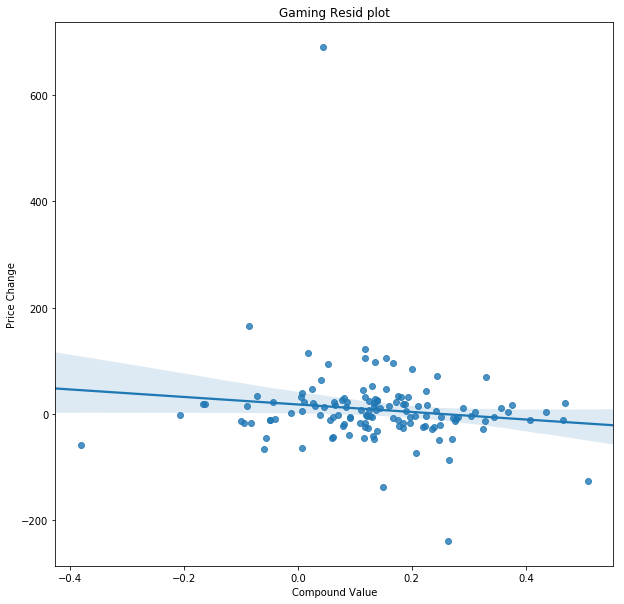

In [1050]:
sns.regplot('compund', 'change', gaming_price_hourly , fit_reg=True )
plt.rcParams['figure.figsize'] = 10,10
plt.title('Gaming Resid plot')
plt.xlabel('Compound Value')
plt.ylabel('Price Change')
plt.show()


# Checking R-squared Values And Correlations 

In [1102]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
res = smf.ols(formula='change ~ label', data=crypto_price_hourly).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 change   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     2.338
Date:                Fri, 20 Apr 2018   Prob (F-statistic):              0.101
Time:                        22:14:24   Log-Likelihood:                -668.94
No. Observations:                 116   AIC:                             1344.
Df Residuals:                     113   BIC:                             1352.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       35.9604     15.665      2.296      0.024       4.924      66.996
label[T.NEU]   -32.6527     19.389     -1.684      0.095     -71.066       5.761
label[T.POS]   -41.6446     19.617     -2.123      0.036     -80.510      -2.779
==============================================================================
Omnibus:                      162.588   Durbin-Watson:                   1.559
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9345.525
Skew:                           5.023   Prob(JB):                         0.00
Kurtosis:                      45.809   Cond. No.                         4.57
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1104]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
res = smf.ols(formula='change ~ label', data=gaming_price_hourly).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 change   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     2.491
Date:                Fri, 20 Apr 2018   Prob (F-statistic):             0.0868
Time:                        22:18:59   Log-Likelihood:                -757.55
No. Observations:                 132   AIC:                             1521.
Df Residuals:                     129   BIC:                             1530.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.0722     18.448      0.058      0.954     -35.428      37.573
label[T.NEU]    18.6049     20.383      0.913      0.363     -21.724      58.934
label[T.POS]   -14.5400     22.195     -0.655      0.514     -58.453      29.373
==============================================================================
Omnibus:                      184.031   Durbin-Watson:                   1.607
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12463.059
Skew:                           5.220   Prob(JB):                         0.00
Kurtosis:                      49.444   Cond. No.                         6.05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

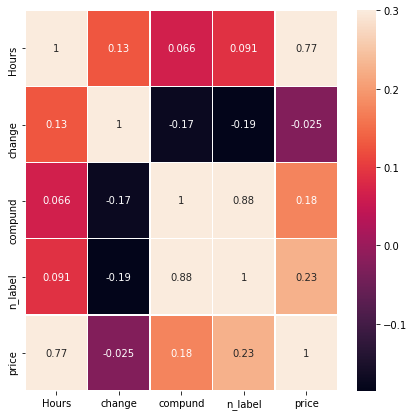

In [1117]:
#dummydf =days[['season', 'holiday', 'weathersit','temp','atemp','hum','windspeed','casual','registered','cnt']].copy()
corr =crypto_price_hourly.corr()

sns.heatmap(corr,vmax=0.3,linewidth=0.5,annot=True)  
plt.rcParams['figure.figsize'] = 7, 7

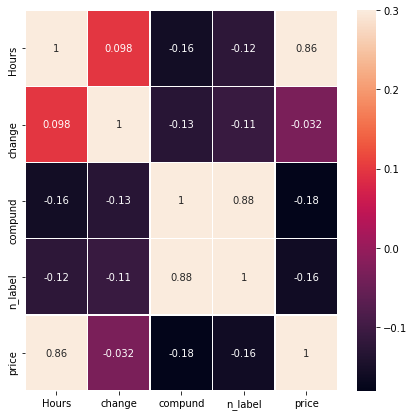

In [1116]:
#dummydf =days[['season', 'holiday', 'weathersit','temp','atemp','hum','windspeed','casual','registered','cnt']].copy()
corr =gaming_price_hourly.corr()

sns.heatmap(corr,vmax=0.3,linewidth=0.5,annot=True)  
plt.rcParams['figure.figsize'] = 7, 7